
# Visualization utilities

This example illustrates some of the utilities that torchvision offers for
visualizing images, bounding boxes, segmentation masks and keypoints.


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

## Visualizing a grid of images
The :func:`~torchvision.utils.make_grid` function can be used to create a
tensor that represents multiple images in a grid.  This util requires a single
image of dtype ``uint8`` as input.



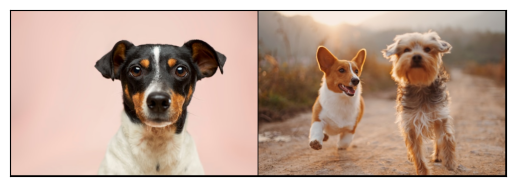

In [3]:
from torchvision.utils import make_grid
from torchvision.io import decode_image
from pathlib import Path

dog1_int = decode_image(str(Path('./assets') / 'dog1.jpg'))
dog2_int = decode_image(str(Path('./assets') / 'dog2.jpg'))
dog_list = [dog1_int, dog2_int]

grid = make_grid(dog_list)
show(grid)

## Visualizing bounding boxes
We can use :func:`~torchvision.utils.draw_bounding_boxes` to draw boxes on an
image. We can set the colors, labels, width as well as font and font size.
The boxes are in ``(xmin, ymin, xmax, ymax)`` format.



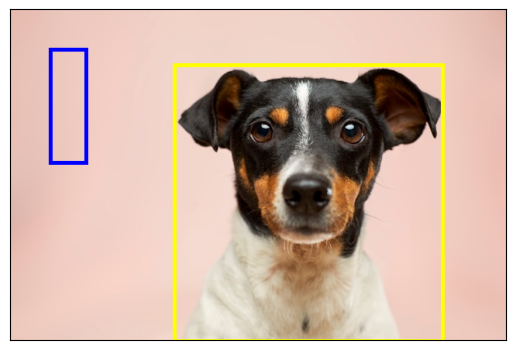

In [4]:
from torchvision.utils import draw_bounding_boxes


boxes = torch.tensor([[50, 50, 100, 200], [210, 70, 560, 430]], dtype=torch.float)
colors = ["blue", "yellow"]
result = draw_bounding_boxes(dog1_int, boxes, colors=colors, width=5)
show(result)

Naturally, we can also plot bounding boxes produced by torchvision detection
models.  Here is a demo with a Faster R-CNN model loaded from
:func:`~torchvision.models.detection.fasterrcnn_resnet50_fpn`
model. For more details on the output of such models, you may
refer to `instance_seg_output`.



In [5]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights


weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

images = [transforms(d) for d in dog_list]

model = fasterrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()

outputs = model(images)
print(outputs)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


[{'boxes': tensor([[213.4388,  65.7325, 559.5813, 423.2905]], grad_fn=<StackBackward0>), 'labels': tensor([18]), 'scores': tensor([0.9977], grad_fn=<IndexBackward0>)}, {'boxes': tensor([[129.0170,  86.2434, 281.7448, 366.3919],
        [319.8537,  43.5992, 520.8027, 420.9405],
        [143.6280,  60.7655, 492.6153, 419.6807]], grad_fn=<StackBackward0>), 'labels': tensor([18, 18, 18]), 'scores': tensor([0.9996, 0.9985, 0.1565], grad_fn=<IndexBackward0>)}]


Let's plot the boxes detected by our model. We will only plot the boxes with a
score greater than a given threshold.



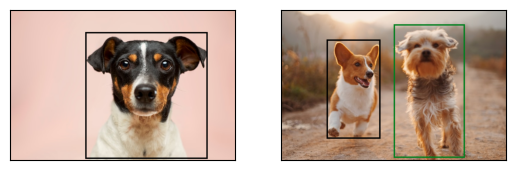

In [6]:
score_threshold = .8
dogs_with_boxes = [
    draw_bounding_boxes(dog_int, boxes=output['boxes'][output['scores'] > score_threshold], width=4)
    for dog_int, output in zip(dog_list, outputs)
]
show(dogs_with_boxes)

## Visualizing segmentation masks
The :func:`~torchvision.utils.draw_segmentation_masks` function can be used to
draw segmentation masks on images. Semantic segmentation and instance
segmentation models have different outputs, so we will treat each
independently.


### Semantic segmentation models

We will see how to use it with torchvision's FCN Resnet-50, loaded with
:func:`~torchvision.models.segmentation.fcn_resnet50`. Let's start by looking
at the output of the model.



In [7]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

weights = FCN_ResNet50_Weights.DEFAULT
transforms = weights.transforms(resize_size=None)

model = fcn_resnet50(weights=weights, progress=False)
model = model.eval()

batch = torch.stack([transforms(d) for d in dog_list])
output = model(batch)['out']
print(output.shape, output.min().item(), output.max().item())

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


torch.Size([2, 21, 427, 640]) -6.202589988708496 13.472983360290527


In [8]:
# model(batch)['out']

As we can see above, the output of the segmentation model is a tensor of shape
``(batch_size, num_classes, H, W)``. Each value is a non-normalized score, and
we can normalize them into ``[0, 1]`` by using a softmax. After the softmax,
we can interpret each value as a probability indicating how likely a given
pixel is to belong to a given class.

Let's plot the masks that have been detected for the dog class and for the
boat class:



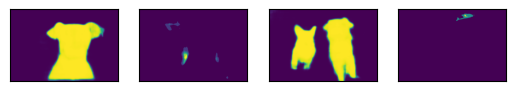

In [11]:
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}

normalized_masks = torch.nn.functional.softmax(output, dim=1)

dog_and_boat_masks = [
    normalized_masks[img_idx, sem_class_to_idx[cls]]
    for img_idx in range(len(dog_list))
    for cls in ('dog', 'boat')
]

show(dog_and_boat_masks)

As expected, the model is confident about the dog class, but not so much for
the boat class.

The :func:`~torchvision.utils.draw_segmentation_masks` function can be used to
plots those masks on top of the original image. This function expects the
masks to be boolean masks, but our masks above contain probabilities in ``[0,
1]``. To get boolean masks, we can do the following:



shape = torch.Size([2, 427, 640]), dtype = torch.bool


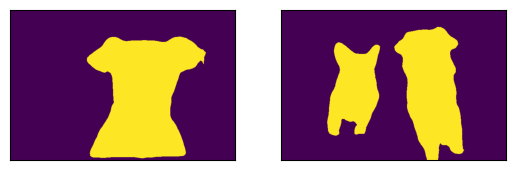

In [12]:
class_dim = 1
boolean_dog_masks = (normalized_masks.argmax(class_dim) == sem_class_to_idx['dog'])
print(f"shape = {boolean_dog_masks.shape}, dtype = {boolean_dog_masks.dtype}")
show([m.float() for m in boolean_dog_masks])

The line above where we define ``boolean_dog_masks`` is a bit cryptic, but you
can read it as the following query: "For which pixels is 'dog' the most likely
class?"

<div class="alert alert-info"><h4>Note</h4><p>While we're using the ``normalized_masks`` here, we would have
  gotten the same result by using the non-normalized scores of the model
  directly (as the softmax operation preserves the order).</p></div>

Now that we have boolean masks, we can use them with
:func:`~torchvision.utils.draw_segmentation_masks` to plot them on top of the
original images:



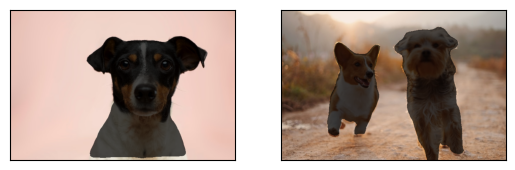

In [13]:
from torchvision.utils import draw_segmentation_masks

dogs_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=0.7)
    for img, mask in zip(dog_list, boolean_dog_masks)
]
show(dogs_with_masks)

We can plot more than one mask per image! Remember that the model returned as
many masks as there are classes. Let's ask the same query as above, but this
time for *all* classes, not just the dog class: "For each pixel and each class
C, is class C the most likely class?"

This one is a bit more involved, so we'll first show how to do it with a
single image, and then we'll generalize to the batch



In [14]:
normalized_masks.shape

torch.Size([2, 21, 427, 640])

In [19]:
# dog1_masks_1999 = normalized_masks[0]
# # dog1_masks_1999  output.min().item(), output.max().item()
# dog1_masks.shape
normalized_masks[0].shape

torch.Size([21, 427, 640])

dog1_masks shape = torch.Size([21, 427, 640]), dtype = torch.float32
dog1_all_classes_masks = torch.Size([21, 427, 640]), dtype = torch.bool


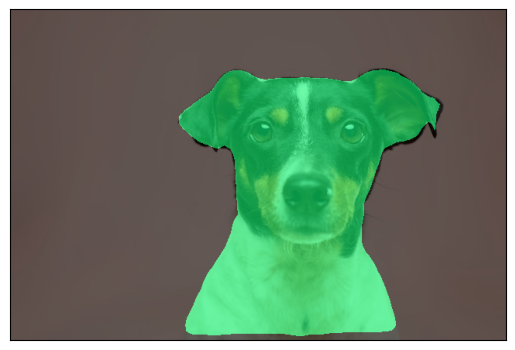

In [20]:
num_classes = normalized_masks.shape[1]
dog1_masks = normalized_masks[0]  # zooms into the batch so now the shape dimension changes to just [C, W, H]
class_dim = 0
dog1_all_classes_masks = dog1_masks.argmax(class_dim) == torch.arange(num_classes)[:, None, None]

print(f"dog1_masks shape = {dog1_masks.shape}, dtype = {dog1_masks.dtype}")
print(f"dog1_all_classes_masks = {dog1_all_classes_masks.shape}, dtype = {dog1_all_classes_masks.dtype}")

dog_with_all_masks = draw_segmentation_masks(dog1_int, masks=dog1_all_classes_masks, alpha=.6)
show(dog_with_all_masks)

In [21]:
print(f"Shape of dog1_masks: {dog1_masks.shape}")
print(f"Size of the first dimension (class_dim): {dog1_masks.shape[0]}")

Shape of dog1_masks: torch.Size([21, 427, 640])
Size of the first dimension (class_dim): 21


We can see in the image above that only 2 masks were drawn: the mask for the
background and the mask for the dog. This is because the model thinks that
only these 2 classes are the most likely ones across all the pixels. If the
model had detected another class as the most likely among other pixels, we
would have seen its mask above.

Removing the background mask is as simple as passing
``masks=dog1_all_classes_masks[1:]``, because the background class is the
class with index 0.

Let's now do the same but for an entire batch of images. The code is similar
but involves a bit more juggling with the dimensions.



In [22]:
normalized_masks.shape

torch.Size([2, 21, 427, 640])

In [25]:
print(normalized_masks.argmax(class_dim).shape)

torch.Size([2, 427, 640])


In [27]:
all_classes_masksVv = normalized_masks.argmax(class_dim) == torch.arange(num_classes)[:, None, None, None]

shape = torch.Size([21, 2, 427, 640]), dtype = torch.bool
After swapping axes:  torch.Size([2, 21, 427, 640])


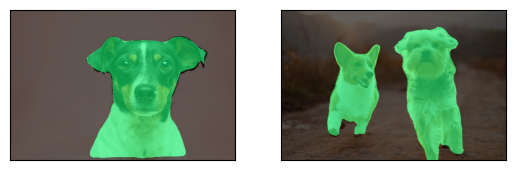

In [23]:
class_dim = 1
all_classes_masks = normalized_masks.argmax(class_dim) == torch.arange(num_classes)[:, None, None, None]
print(f"shape = {all_classes_masks.shape}, dtype = {all_classes_masks.dtype}")
# The first dimension is the classes now, so we need to swap it
all_classes_masks = all_classes_masks.swapaxes(0, 1)
print("After swapping axes: ", all_classes_masks.shape)

dogs_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=.6)
    for img, mask in zip(dog_list, all_classes_masks)
]
show(dogs_with_masks)


### Instance segmentation models

Instance segmentation models have a significantly different output from the
semantic segmentation models. We will see here how to plot the masks for such
models. Let's start by analyzing the output of a Mask-RCNN model. Note that
these models don't require the images to be normalized, so we don't need to
use the normalized batch.

<div class="alert alert-info"><h4>Note</h4><p>We will here describe the output of a Mask-RCNN model. The models in
    `object_det_inst_seg_pers_keypoint_det` all have a similar output
    format, but some of them may have extra info like keypoints for
    :func:`~torchvision.models.detection.keypointrcnn_resnet50_fpn`, and some
    of them may not have masks, like
    :func:`~torchvision.models.detection.fasterrcnn_resnet50_fpn`.</p></div>



In [29]:
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

images = [transforms(d) for d in dog_list]

model = maskrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()

output = model(images)
print(output)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


[{'boxes': tensor([[219.1331,  67.9414, 551.7408, 422.4829]], grad_fn=<StackBackward0>), 'labels': tensor([18]), 'scores': tensor([0.9986], grad_fn=<IndexBackward0>), 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], grad_fn=<UnsqueezeBackward0>)}, {'boxes': tensor([[126.5546,  92.5832, 281.9369, 365.9790],
        [322.4889,  47.3486, 520.7331, 422.1323],
        [172.9144,  56.9198, 491.2267, 423.3726]], grad_fn=<StackBackward0>), 'labels': tensor([18, 18, 18]), 'scores': tensor([0.9994, 0.9994, 0.1329], grad_fn=<IndexBackward0>), 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]

Let's break this down. For each image in the batch, the model outputs some
detections (or instances). The number of detections varies for each input
image. Each instance is described by its bounding box, its label, its score
and its mask.

The way the output is organized is as follows: the output is a list of length
``batch_size``. Each entry in the list corresponds to an input image, and it
is a dict with keys 'boxes', 'labels', 'scores', and 'masks'. Each value
associated to those keys has ``num_instances`` elements in it.  In our case
above there are 3 instances detected in the first image, and 2 instances in
the second one.

The boxes can be plotted with :func:`~torchvision.utils.draw_bounding_boxes`
as above, but here we're more interested in the masks. These masks are quite
different from the masks that we saw above for the semantic segmentation
models.



In [34]:
output[0]

{'boxes': tensor([[219.1331,  67.9414, 551.7408, 422.4829]], grad_fn=<StackBackward0>),
 'labels': tensor([18]),
 'scores': tensor([0.9986], grad_fn=<IndexBackward0>),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]], grad_fn=<UnsqueezeBackward0>)}

In [30]:
dog1_output = output[0]
dog1_masks = dog1_output['masks']
print(f"shape = {dog1_masks.shape}, dtype = {dog1_masks.dtype}, "
      f"min = {dog1_masks.min()}, max = {dog1_masks.max()}")

shape = torch.Size([1, 1, 427, 640]), dtype = torch.float32, min = 0.0, max = 0.9999771118164062


Here the masks correspond to probabilities indicating, for each pixel, how
likely it is to belong to the predicted label of that instance. Those
predicted labels correspond to the 'labels' element in the same output dict.
Let's see which labels were predicted for the instances of the first image.



In [35]:
print("For the first dog, the following instances were detected:")
print([weights.meta["categories"][label] for label in dog1_output['labels']])

For the first dog, the following instances were detected:
['dog']


Interestingly, the model detects two persons in the image. Let's go ahead and
plot those masks. Since :func:`~torchvision.utils.draw_segmentation_masks`
expects boolean masks, we need to convert those probabilities into boolean
values. Remember that the semantic of those masks is "How likely is this pixel
to belong to the predicted class?". As a result, a natural way of converting
those masks into boolean values is to threshold them with the 0.5 probability
(one could also choose a different threshold).



shape = torch.Size([1, 1, 427, 640]), dtype = torch.bool


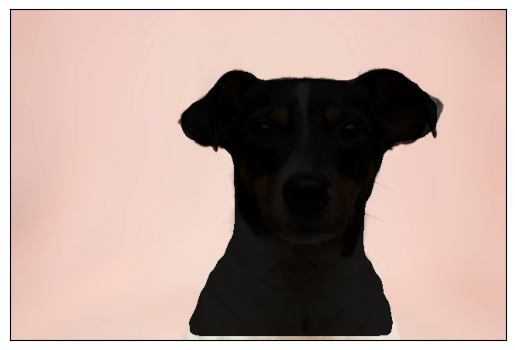

In [36]:
proba_threshold = 0.5
dog1_bool_masks = dog1_output['masks'] > proba_threshold
print(f"shape = {dog1_bool_masks.shape}, dtype = {dog1_bool_masks.dtype}")

# There's an extra dimension (1) to the masks. We need to remove it
dog1_bool_masks = dog1_bool_masks.squeeze(1)

show(draw_segmentation_masks(dog1_int, dog1_bool_masks, alpha=0.9))

The model seems to have properly detected the dog, but it also confused trees
with people. Looking more closely at the scores will help us plot more
relevant masks:



In [37]:
print(dog1_output['scores'])

tensor([0.9986], grad_fn=<IndexBackward0>)


Clearly the model is more confident about the dog detection than it is about
the people detections. That's good news. When plotting the masks, we can ask
for only those that have a good score. Let's use a score threshold of .75
here, and also plot the masks of the second dog.



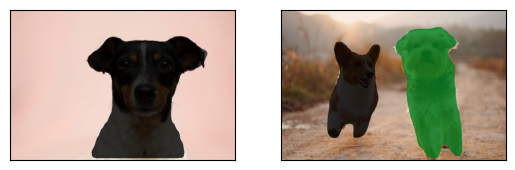

In [38]:
score_threshold = .75

boolean_masks = [
    out['masks'][out['scores'] > score_threshold] > proba_threshold
    for out in output
]

dogs_with_masks = [
    draw_segmentation_masks(img, mask.squeeze(1))
    for img, mask in zip(dog_list, boolean_masks)
]
show(dogs_with_masks)

The two 'people' masks in the first image where not selected because they have
a lower score than the score threshold. Similarly, in the second image, the
instance with class 15 (which corresponds to 'bench') was not selected.




## Visualizing keypoints
The :func:`~torchvision.utils.draw_keypoints` function can be used to
draw keypoints on images. We will see how to use it with
torchvision's KeypointRCNN loaded with :func:`~torchvision.models.detection.keypointrcnn_resnet50_fpn`.
We will first have a look at output of the model.




In [48]:
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights
from torchvision.io import decode_image

person_int = decode_image(str(Path("./assets") / "person1.jpg"))

weights = KeypointRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

person_float = transforms(person_int)

model = keypointrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()

outputs = model([person_float])
print(outputs)

[{'boxes': tensor([[267.0239,  99.7496, 377.7607, 373.4308],
        [265.8328, 228.5798, 365.0338, 367.4927]], grad_fn=<StackBackward0>), 'labels': tensor([1, 1]), 'scores': tensor([0.9982, 0.0692], grad_fn=<IndexBackward0>), 'keypoints': tensor([[[354.0694, 144.2962,   1.0000],
         [358.3285, 142.6957,   1.0000],
         [355.6666, 139.4947,   1.0000],
         [346.0836, 127.2244,   1.0000],
         [346.6159, 127.7579,   1.0000],
         [334.3710, 153.3655,   1.0000],
         [312.5431, 152.8320,   1.0000],
         [330.6443, 193.3774,   1.0000],
         [294.4419, 202.4467,   1.0000],
         [342.8893, 246.7265,   1.0000],
         [294.4419, 250.9945,   1.0000],
         [322.6585, 245.6595,   1.0000],
         [308.8164, 249.3940,   1.0000],
         [351.9398, 305.4106,   1.0000],
         [351.9398, 305.9441,   1.0000],
         [320.5290, 349.6904,   1.0000],
         [275.8083, 372.6305,   1.0000]],

        [[293.8330, 228.8459,   1.0000],
         [275.6995, 

As we see the output contains a list of dictionaries.
The output list is of length batch_size.
We currently have just a single image so length of list is 1.
Each entry in the list corresponds to an input image,
and it is a dict with keys `boxes`, `labels`, `scores`, `keypoints` and `keypoint_scores`.
Each value associated to those keys has `num_instances` elements in it.
In our case above there are 2 instances detected in the image.



In [49]:
kpts = outputs[0]['keypoints']
scores = outputs[0]['scores']

print(kpts)
print(scores)

tensor([[[354.0694, 144.2962,   1.0000],
         [358.3285, 142.6957,   1.0000],
         [355.6666, 139.4947,   1.0000],
         [346.0836, 127.2244,   1.0000],
         [346.6159, 127.7579,   1.0000],
         [334.3710, 153.3655,   1.0000],
         [312.5431, 152.8320,   1.0000],
         [330.6443, 193.3774,   1.0000],
         [294.4419, 202.4467,   1.0000],
         [342.8893, 246.7265,   1.0000],
         [294.4419, 250.9945,   1.0000],
         [322.6585, 245.6595,   1.0000],
         [308.8164, 249.3940,   1.0000],
         [351.9398, 305.4106,   1.0000],
         [351.9398, 305.9441,   1.0000],
         [320.5290, 349.6904,   1.0000],
         [275.8083, 372.6305,   1.0000]],

        [[293.8330, 228.8459,   1.0000],
         [275.6995, 367.2265,   1.0000],
         [295.4331, 253.3287,   1.0000],
         [364.7671, 228.8459,   1.0000],
         [364.7671, 228.8459,   1.0000],
         [303.9665, 228.8459,   1.0000],
         [301.2998, 240.0228,   1.0000],
         [293.

The KeypointRCNN model detects there are two instances in the image.
If you plot the boxes by using :func:`~draw_bounding_boxes`
you would recognize they are the person and the surfboard.
If we look at the scores, we will realize that the model is much more confident about the person than surfboard.
We could now set a threshold confidence and plot instances which we are confident enough.
Let us set a threshold of 0.75 and filter out the keypoints corresponding to the person.



In [50]:
detect_threshold = 0.75
idx = torch.where(scores > detect_threshold)
keypoints = kpts[idx]

print(keypoints)

tensor([[[354.0694, 144.2962,   1.0000],
         [358.3285, 142.6957,   1.0000],
         [355.6666, 139.4947,   1.0000],
         [346.0836, 127.2244,   1.0000],
         [346.6159, 127.7579,   1.0000],
         [334.3710, 153.3655,   1.0000],
         [312.5431, 152.8320,   1.0000],
         [330.6443, 193.3774,   1.0000],
         [294.4419, 202.4467,   1.0000],
         [342.8893, 246.7265,   1.0000],
         [294.4419, 250.9945,   1.0000],
         [322.6585, 245.6595,   1.0000],
         [308.8164, 249.3940,   1.0000],
         [351.9398, 305.4106,   1.0000],
         [351.9398, 305.9441,   1.0000],
         [320.5290, 349.6904,   1.0000],
         [275.8083, 372.6305,   1.0000]]], grad_fn=<IndexBackward0>)


Great, now we have the keypoints corresponding to the person.
Each keypoint is represented by x, y coordinates and the visibility.
We can now use the :func:`~torchvision.utils.draw_keypoints` function to draw keypoints.
Note that the utility expects uint8 images.



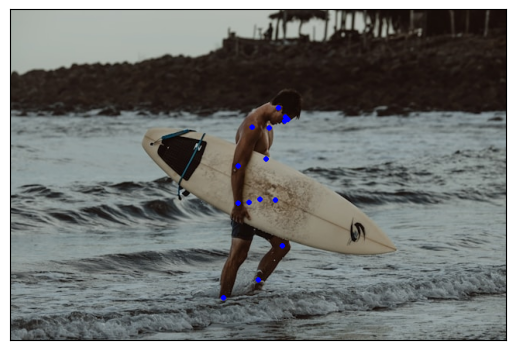

In [52]:
from torchvision.utils import draw_keypoints

res = draw_keypoints(person_int, keypoints, colors="blue", radius=3)
show(res)

As we see, the keypoints appear as colored circles over the image.
The coco keypoints for a person are ordered and represent the following list.\



In [53]:
coco_keypoints = [
    "nose", "left_eye", "right_eye", "left_ear", "right_ear",
    "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
    "left_wrist", "right_wrist", "left_hip", "right_hip",
    "left_knee", "right_knee", "left_ankle", "right_ankle",
]

What if we are interested in joining the keypoints?
This is especially useful in creating pose detection or action recognition.
We can join the keypoints easily using the `connectivity` parameter.
A close observation would reveal that we would need to join the points in below
order to construct human skeleton.

nose -> left_eye -> left_ear.                              (0, 1), (1, 3)

nose -> right_eye -> right_ear.                            (0, 2), (2, 4)

nose -> left_shoulder -> left_elbow -> left_wrist.         (0, 5), (5, 7), (7, 9)

nose -> right_shoulder -> right_elbow -> right_wrist.      (0, 6), (6, 8), (8, 10)

left_shoulder -> left_hip -> left_knee -> left_ankle.      (5, 11), (11, 13), (13, 15)

right_shoulder -> right_hip -> right_knee -> right_ankle.  (6, 12), (12, 14), (14, 16)

We will create a list containing these keypoint ids to be connected.



In [54]:
connect_skeleton = [
    (0, 1), (0, 2), (1, 3), (2, 4), (0, 5), (0, 6), (5, 7), (6, 8),
    (7, 9), (8, 10), (5, 11), (6, 12), (11, 13), (12, 14), (13, 15), (14, 16)
]

We pass the above list to the connectivity parameter to connect the keypoints.




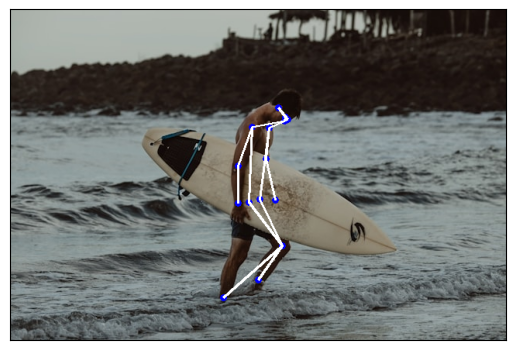

In [55]:
res = draw_keypoints(person_int, keypoints, connectivity=connect_skeleton, colors="blue", radius=4, width=3)
show(res)

That looks pretty good.


### Drawing Keypoints with Visibility
Let's have a look at the results, another keypoint prediction module produced, and show the connectivity:



In [58]:
predicted_keypoints = outputs[0]['keypoints']
predicted_scores = outputs[0]['scores'] # You might also want the scores to filter results

In [60]:
predicted_scores, predicted_keypoints

(tensor([0.9982, 0.0692], grad_fn=<IndexBackward0>),
 tensor([[[354.0694, 144.2962,   1.0000],
          [358.3285, 142.6957,   1.0000],
          [355.6666, 139.4947,   1.0000],
          [346.0836, 127.2244,   1.0000],
          [346.6159, 127.7579,   1.0000],
          [334.3710, 153.3655,   1.0000],
          [312.5431, 152.8320,   1.0000],
          [330.6443, 193.3774,   1.0000],
          [294.4419, 202.4467,   1.0000],
          [342.8893, 246.7265,   1.0000],
          [294.4419, 250.9945,   1.0000],
          [322.6585, 245.6595,   1.0000],
          [308.8164, 249.3940,   1.0000],
          [351.9398, 305.4106,   1.0000],
          [351.9398, 305.9441,   1.0000],
          [320.5290, 349.6904,   1.0000],
          [275.8083, 372.6305,   1.0000]],
 
         [[293.8330, 228.8459,   1.0000],
          [275.6995, 367.2265,   1.0000],
          [295.4331, 253.3287,   1.0000],
          [364.7671, 228.8459,   1.0000],
          [364.7671, 228.8459,   1.0000],
          [303.9665,

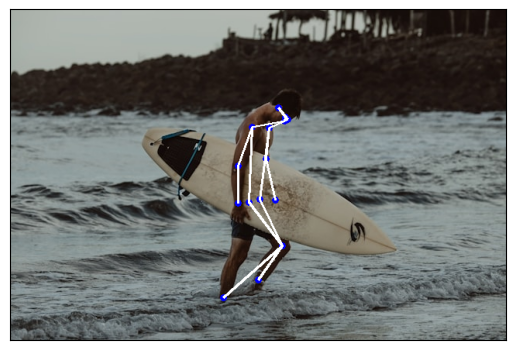

In [66]:
prediction = torch.tensor(
  [[[354.0694, 144.2962,   1.0000],
    [358.3285, 142.6957,   1.0000],
    [355.6666, 139.4947,   1.0000],
    [346.0836, 127.2244,   1.0000],
    [346.6159, 127.7579,   1.0000],
    [334.3710, 153.3655,   1.0000],
    [312.5431, 152.8320,   1.0000],
    [330.6443, 193.3774,   1.0000],
    [294.4419, 202.4467,   1.0000],
    [342.8893, 246.7265,   1.0000],
    [294.4419, 250.9945,   1.0000],
    [322.6585, 245.6595,   1.0000],
    [308.8164, 249.3940,   1.0000],
    [351.9398, 305.4106,   1.0000],
    [351.9398, 305.9441,   1.0000],
    [320.5290, 349.6904,   1.0000],
    [275.8083, 372.6305,   1.0000]]],
)

res = draw_keypoints(person_int, prediction, connectivity=connect_skeleton, colors="blue", radius=4, width=3)
show(res)

What happened there?
The model, which predicted the new keypoints,
can't detect the three points that are hidden on the upper left body of the skateboarder.
More precisely, the model predicted that `(x, y, vis) = (0, 0, 0)` for the left_eye, left_ear, and left_hip.
So we definitely don't want to display those keypoints and connections, and you don't have to.
Looking at the parameters of :func:`~torchvision.utils.draw_keypoints`,
we can see that we can pass a visibility tensor as an additional argument.
Given the models' prediction, we have the visibility as the third keypoint dimension, we just need to extract it.
Let's split the ``prediction`` into the keypoint coordinates and their respective visibility,
and pass both of them as arguments to :func:`~torchvision.utils.draw_keypoints`.



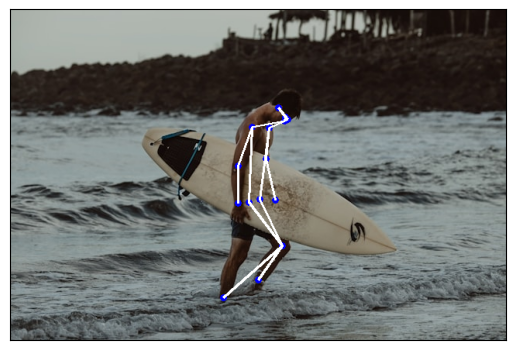

In [64]:
coordinates, visibility = prediction.split([2, 1], dim=-1)
visibility = visibility.bool()

res = draw_keypoints(
    person_int, coordinates, visibility=visibility, connectivity=connect_skeleton, colors="blue", radius=4, width=3
)
show(res)

We can see that the undetected keypoints are not draw and the invisible keypoint connections were skipped.
This can reduce the noise on images with multiple detections, or in cases like ours,
when the keypoint-prediction model missed some detections.
Most torch keypoint-prediction models return the visibility for every prediction, ready for you to use it.
The :func:`~torchvision.models.detection.keypointrcnn_resnet50_fpn` model,
which we used in the first case, does so too.

